In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

mnist_data = datasets.MNIST(root='./data', train = True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True
                                          )

100%|██████████| 9912422/9912422 [00:00<00:00, 132222706.76it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39291499.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46786530.71it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19399723.80it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
dataiter = iter(data_loader)
images, lebels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder_Linear(nn.Module):
  def __init__(self):
    #N, 784
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), #N, 784 -> N, 128
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3) # N, 3
    )
    self.decoder = nn.Sequential(
        nn.Linear(3, 12),
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28), # N, 3 -> N, 784
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  # Note: [-1, 1] --> nn.Tanh

In [11]:
class Autoencoder(nn.Module):
  def __init__(self):
    #N, 1, 28, 28
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7) # N, 64, 1, 1
    )
    # N, 64, 1, 1
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  # Note: [-1, 1] --> nn.Tanh
  # nn.MaxPool2d --> nn.MaxUnpool2d

In [12]:
model_type = 'conv'
if model_type == 'linear':
  model = Autoencoder_Linear()
  print("Your model type is linear")
elif model_type == 'conv':
  model = Autoencoder()
  print("Your model type is conv")
else:
  print("This Type model is not found. You can impliment...")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Your model type is conv


In [13]:
#For Linear
num_epoch = 10
outputs = []

for epoch in range(num_epoch):
  for(img, _) in data_loader:
    if model_type == 'linear':
      img = img.reshape(-1, 28*28)
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch: {epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch: 1, Loss:0.0084
Epoch: 2, Loss:0.0045
Epoch: 3, Loss:0.0038
Epoch: 4, Loss:0.0030
Epoch: 5, Loss:0.0033
Epoch: 6, Loss:0.0028
Epoch: 7, Loss:0.0026
Epoch: 8, Loss:0.0034
Epoch: 9, Loss:0.0034
Epoch: 10, Loss:0.0033


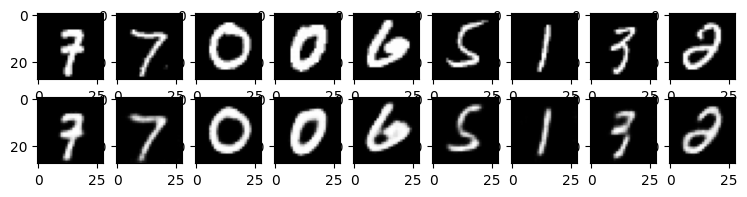

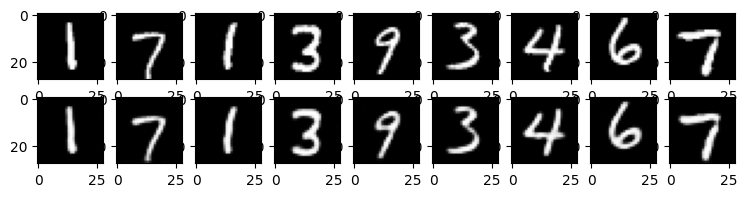

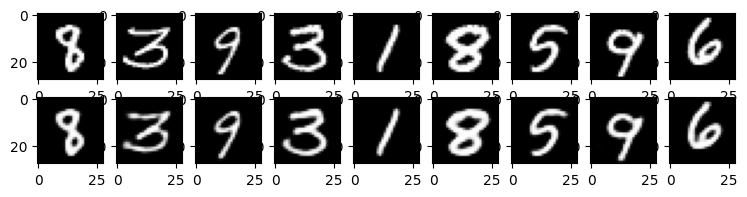

In [14]:
for k in range(0, num_epoch, 4):
  plt.figure(figsize=(9, 2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i>=9: break
    plt.subplot(2, 9, i+1)
    if model_type == 'linear':
      item = item.reshape(-1, 28,28)
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i>=9: break
    plt.subplot(2, 9, 9+i+1)
    if model_type == 'linear':
      item = item.reshape(-1, 28,28)
    plt.imshow(item[0])

In [ ]:
#  MaxPool2d, inspect the encoded data